<a href="https://colab.research.google.com/github/Bhuvaneswarij/gitingest/blob/main/Time%20series%20forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

date_rng = pd.date_range(start='2020-01-01', end='2020-06-01', freq='D')
values = 20 + 5*np.sin(np.linspace(0, 10, len(date_rng))) + np.random.normal(0, 1, len(date_rng))

df = pd.DataFrame({'date': date_rng, 'value': values})
df.set_index('date', inplace=True)
df.head()


,value
date,
2020-01-01,20.670789
2020-01-02,19.070093
2020-01-03,19.874227
2020-01-04,20.340158
2020-01-05,19.906198


In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['scaled'] = scaler.fit_transform(df[['value']])

def create_sequences(data, seq_len=14):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 14
X, y = create_sequences(df['scaled'].values, seq_len)

# Train-test split
size = int(len(X)*0.8)
X_train, X_test = X[:size], X[size:]
y_train, y_test = y[:size], y[size:]

X_train = X_train.reshape((X_train.shape[0], seq_len, 1))
X_test = X_test.reshape((X_test.shape[0], seq_len, 1))


In [3]:
import tensorflow as tf

def quantile_loss(q, y_true, y_pred):
    err = y_true - y_pred
    return tf.reduce_mean(tf.maximum(q*err, (q-1)*err))


In [4]:
from tensorflow.keras import layers, models

quantiles = [0.1, 0.5, 0.9]

def multi_quantile_loss(y_true, y_pred):
    losses = []
    for i, q in enumerate(quantiles):
        pred_q = y_pred[:, i:i+1]
        losses.append(quantile_loss(q, y_true, pred_q))
    return tf.reduce_mean(losses)

def build_model():
    model = models.Sequential([
        layers.LSTM(64, return_sequences=False, input_shape=(seq_len,1)),
        layers.Dense(32, activation='relu'),
        layers.Dense(3)  # 3 quantiles
    ])
    model.compile(optimizer='adam', loss=multi_quantile_loss)
    return model

model = build_model()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,075 (74.51 KB)

 Trainable params: 19,075 (74.51 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.1987 - val_loss: 0.3117
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1686 - val_loss: 0.2136
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1108 - val_loss: 0.0945
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0915 - val_loss: 0.0697
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0825 - val_loss: 0.0782
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0815 - val_loss: 0.0873
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0780 - val_loss: 0.0718
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0751 - val_loss: 0.0742
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0726 - val_loss: 0.0788
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0719 - val_loss: 0.0795
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0705 - val_loss: 0.0686
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0696 - val_loss: 0.0775
E

In [12]:
pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


In [13]:
lower = scaler.inverse_transform(pred[:,0].reshape(-1,1))
median = scaler.inverse_transform(pred[:,1].reshape(-1,1))
upper = scaler.inverse_transform(pred[:,2].reshape(-1,1))

actual = scaler.inverse_transform(y_test.reshape(-1,1))


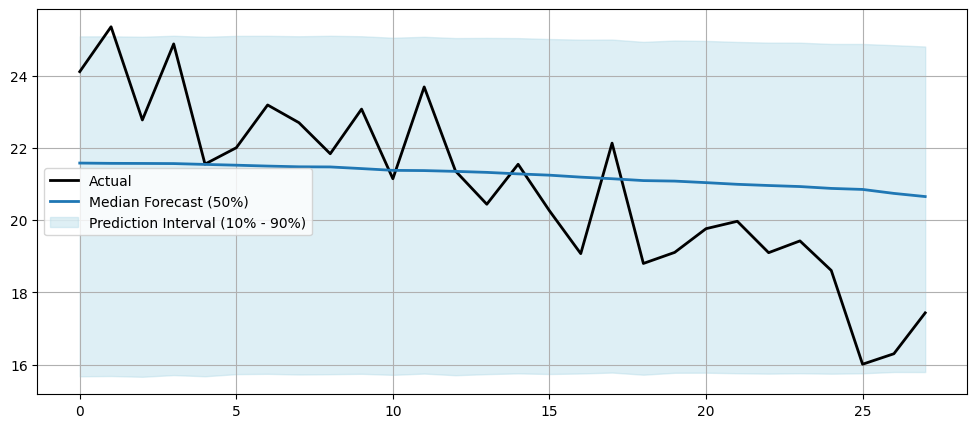

In [14]:
import matplotlib.pyplot as plt
import numpy as np

actual_flat = actual.flatten()
median_flat = median.flatten()
lower_flat = lower.flatten()
upper_flat = upper.flatten()

plt.figure(figsize=(12,5))
plt.plot(actual_flat, label='Actual', linewidth=2, color='black')
plt.plot(median_flat, label='Median Forecast (50%)', linewidth=2)
plt.fill_between(
    np.arange(len(median_flat)),
    lower_flat,
    upper_flat,
    color='lightblue',
    alpha=0.4,
    label='Prediction Interval (10% - 90%)'
)
plt.legend()
plt.grid(True)
plt.show()
